In [2]:
from main_class import PhysicsInformedGP_regressor
import numpy as np


### First example   
forced damped oscillator:   
\begin{equation}
 \ddot{x} + b\dot{x} + k x = f(t) \; \; \mathrm{ with \; m = 1}
\end{equation}

 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\PI_GP_regressor\main_class.py:557: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\PI_GP_regressor\main_class.py:566: UserWarning:The balance properties of Sobol' points require n to be a power of 2.


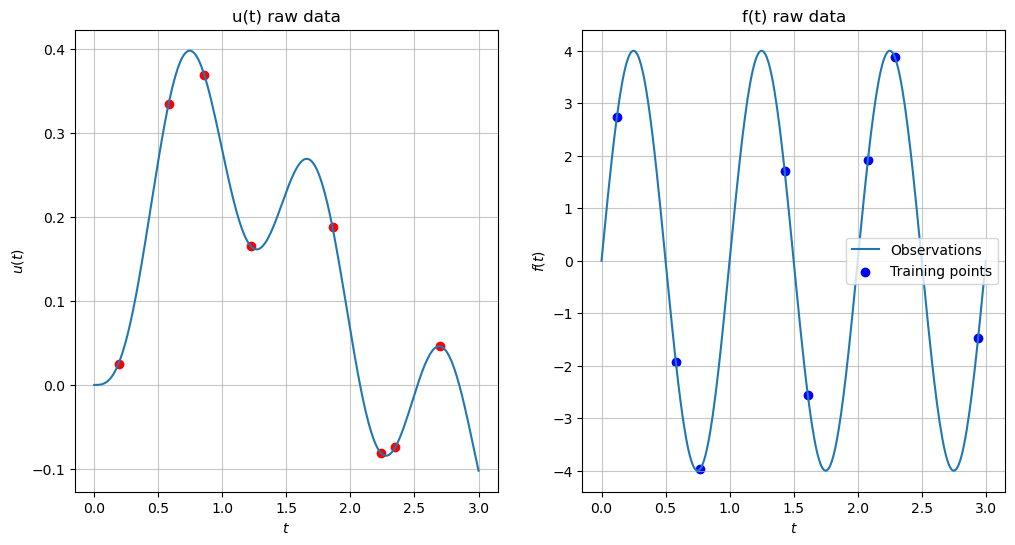

In [3]:
from kernels.kernel_oscillator import gram_Matrix, k_ff, k_uf, k_fu, k_uu
Kernel = [gram_Matrix, k_uu, k_uf, k_fu, k_ff]
params = ["l_x", "sigma_f_sq", "b", "k"]
model_1 = PhysicsInformedGP_regressor(kernel =Kernel, timedependence = False,params=params)
model_1.set_name_kernel("oscillator")
n_training_points = 8
noise = [1e-6,1e-6]
model_1.set_training_data("data_files/damped_m1k2b1.csv", n_training_points, noise)
model_1.set_validation_data(2000)
model_1.plot_raw_data(Training_points=True)



No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


 C:\Users\Razer\AppData\Local\Temp\ipykernel_212644\2799943307.py:12: RuntimeWarning:covariance is not positive-semidefinite.


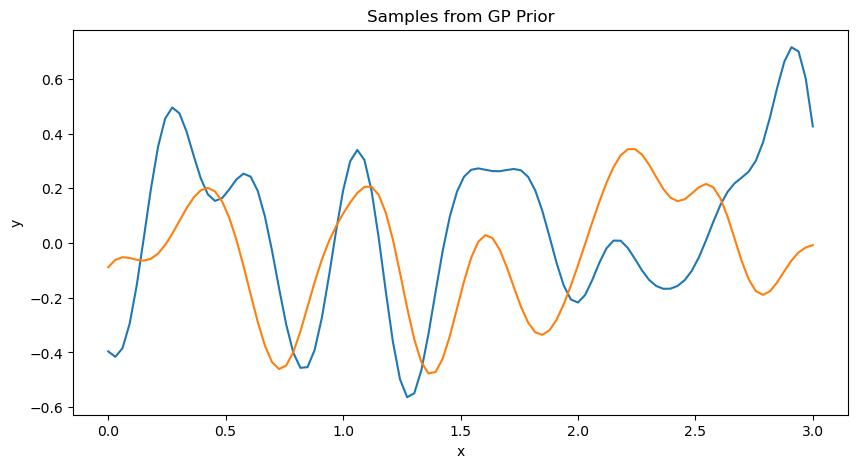

In [4]:
import matplotlib.pyplot as plt
n_functions = 2
n_samples = 100
# Sample x values
x = np.linspace(0, 3, n_samples)
x2 = np.linspace(0, 3, n_samples*2)
hyperparameters = [0.18916745, 0.04958991, 1, 5]
# Calculate the kernel matrix
K = k_fu(x, x, hyperparameters)

# Draw samples from a multivariate normal distribution
y_samples = np.random.multivariate_normal(mean=np.zeros(n_samples), cov=K, size=n_functions)
fig = plt.figure(figsize=(10, 5))
# Plot the samples
for i in range(n_functions):
    
    plt.plot(x, y_samples[i, :])

    plt.title('Samples from GP Prior')
    plt.xlabel('x')
    plt.ylabel('y')


In [5]:
def get_initial_values():
    """returns the initial values for the hyperparameters
    for the length scales we initialize them randomly as log(l) ~ U(-2.5,1)
    """
    rng = np.random.default_rng()
    theta_initial = np.zeros((4))
    theta_initial[0] = np.exp(rng.uniform(-1.3, 0.3, 1))
    theta_initial[1] = rng.uniform(0, 2, 1)
    theta_initial[2] = rng.uniform(1, 3, 1)
    theta_initial[3] = rng.uniform(1, 3, 1)
    return theta_initial
n_iterations, n_threads = 100, -1
model_1.train("CG",n_iterations,n_threads,{'theta_initial': get_initial_values,   #needed for all optimization methods
                            'bounds': ((1e-2, None), (1e-2, None), (1e-1, None),(1e-2, None)), #needed for TNC and L-BFGS-B
                            'gtol': 1e-8})

100%|██████████| 100/100 [00:10<00:00,  9.29it/s]


     fun: 1.6312899589538574
     jac: array([0., 0., 0., 0.])
 message: 'Optimization terminated successfully.'
    nfev: 5
     nit: 0
    njev: 1
  status: 0
 success: True
       x: array([0.49321394, 0.48311192, 1.02206142, 1.96100489])


-----------------------------------------------
GP with kernel: 
Training data: (8, 1)
Training targets: (16, 1)
Hyperparameters: {'l_x': 0.49321394483284325, 'sigma_f_sq': 0.48311191696711164, 'b': 1.022061418673118, 'k': 1.9610048868942247}
Log marginal likelihood: 1.6312899589538574
Mean squared error: {'u': 4.235015239828499e-06, 'f': 0.007342326454818249}
-----------------------------------------------



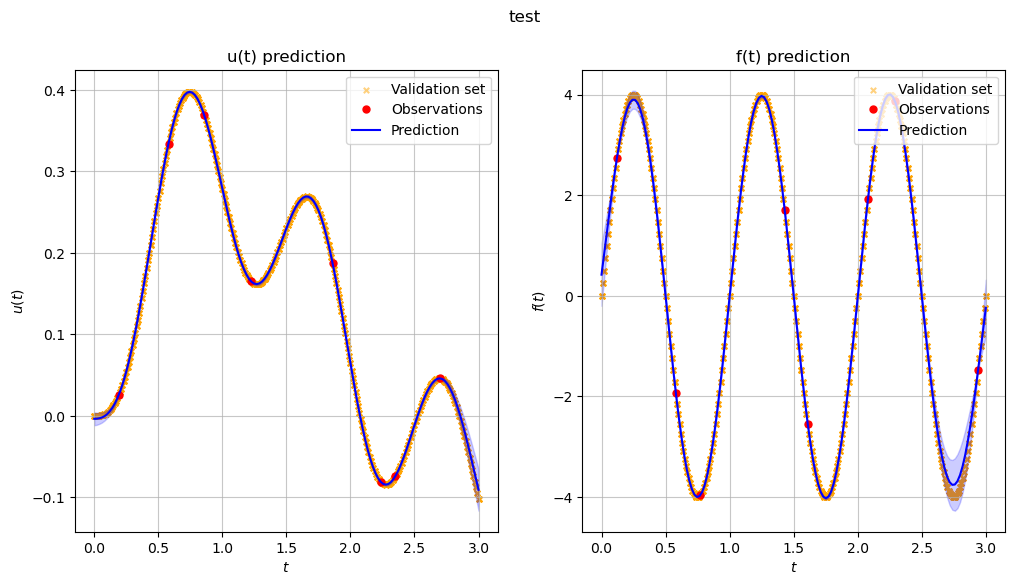

In [6]:
X_star = np.linspace(0,3,150).reshape(-1,1)
model_1.predict_model(X_star)
model_1.mean_u.shape
model_1.plot_prediction(X_star,"test","plots/oscillator/prediction_1d.png")
model_1.error()
print(model_1)

0.0006532859144490319


{'dataplot': [<matplotlib.collections.PathCollection at 0x1572199efa0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x157219ad550>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x157219ad760>]}

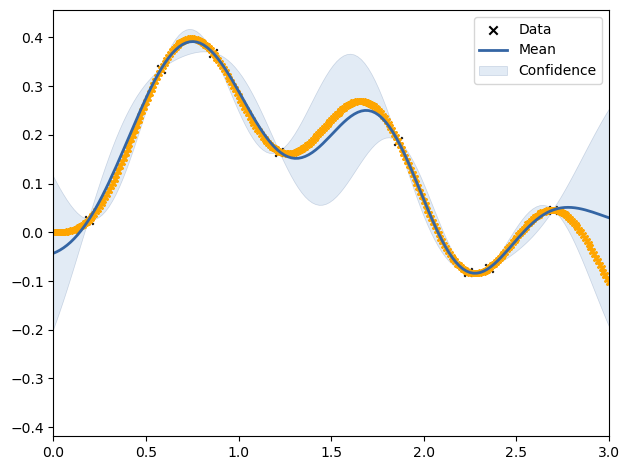

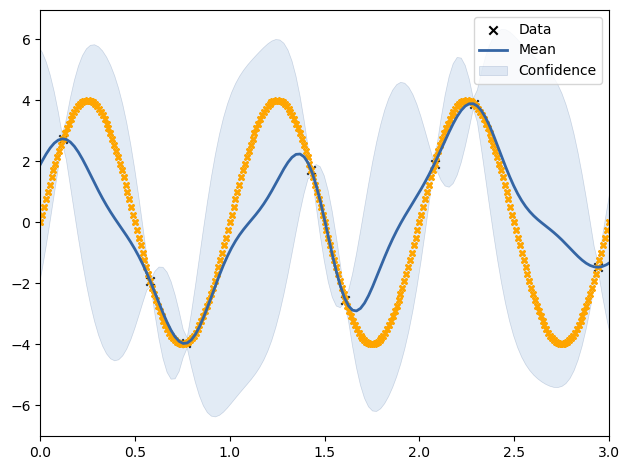

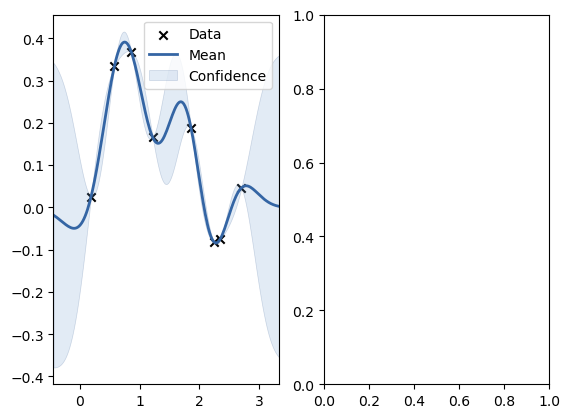

In [9]:
import GPy
import matplotlib.pyplot as plt
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
model_GPy = GPy.models.GPRegression(model_1.X, model_1.u_train, kernel)
model_GPy.Gaussian_noise.variance.fix(noise[0])
model_GPy.optimize_restarts(num_restarts = 20, verbose=False)
model_GPy.plot()
plt.scatter(model_1.validation_set[0],model_1.validation_set[1], label = "validation set", color = "orange", marker = "x", s = 15)
plt.xlim(0,3)
kernel2 = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
model_GPy2 = GPy.models.GPRegression(model_1.Y, model_1.f_train, kernel2)
model_GPy2.Gaussian_noise.variance.fix(noise[1])
model_GPy2.optimize_restarts(num_restarts = 20, verbose=False)
model_GPy2.plot()
plt.scatter(model_1.validation_set[2],model_1.validation_set[3], label = "validation set", color = "orange", marker = "x", s = 15)
plt.xlim(0,3)

error = np.mean((model_1.validation_set[1]- model_GPy.predict(model_1.validation_set[0])[0])**2)
print(error)
fig, ax = plt.subplots(1,2)
model_GPy.plot(ax=ax[0])



### Second example
Wave equation:
\begin{equation}
 \frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2} \; \; \mathrm{ with \; c = 3}
\end{equation}

 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\PI_GP_regressor\main_class.py:609: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\PI_GP_regressor\main_class.py:619: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\PI_GP_regressor\main_class.py:650: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\PI_GP_regressor\main_class.py:660: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


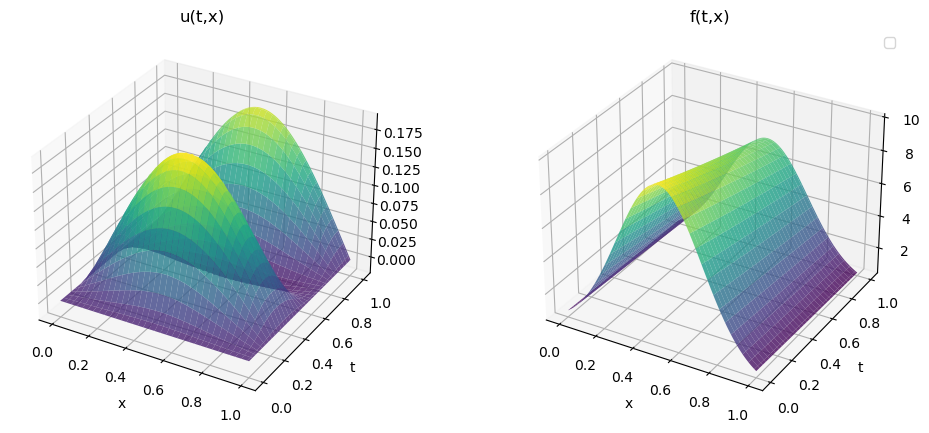

In [2]:
from main_class import PhysicsInformedGP_regressor
from kernels.kernel_helmholtz import gram_Matrix, k_ff, k_uf, k_fu, k_uu
from kernels.kernel_helmholtz import gram_Matrix_jax, k_ff_jax, k_uf_jax, k_fu_jax, k_uu
import numpy as np
Kernel = [gram_Matrix, k_uu, k_uf, k_fu, k_ff]
Kernel_jax = [gram_Matrix_jax, k_uu, k_uf_jax, k_fu_jax, k_ff_jax]
params = ["l_x", "sigma_f_sq", "l_t", "c"]
model_2 = PhysicsInformedGP_regressor(kernel =Kernel_jax, timedependence = True,params=params)
model_2.set_name_kernel("helmholtz")
n_training_points = 25
noise = [1e-5,1e-5]
model_2.set_training_data("data_files/gaussian_f_c3.csv", n_training_points, noise)
model_2.set_validation_data(2000)
model_2.plot_raw_data()

In [5]:
def get_initial_values():
    """returns the initial values for the hyperparameters
    for the length scales we initialize them randomly as log(l) ~ U(-2.5,1)
    """
    rng = np.random.default_rng()
    theta_initial = np.zeros((4))
    theta_initial[0] = np.exp(rng.uniform(-1.3, 0.3, 1))
    theta_initial[1] = rng.uniform(0, 2, 1)
    theta_initial[2] = np.exp(rng.uniform(-1.3, 0.3, 1))
    theta_initial[3] = rng.uniform(1, 4, 1)
    return theta_initial
n_iterations, n_threads = 1000, -1
model_2.train("CG",n_iterations,n_threads,{'theta_initial': get_initial_values,   #needed for all optimization methods
                                            'bounds': ((1e-2, None), (1e-2, None), (1e-1, None),(1e-2, None)), #needed for TNC and L-BFGS-B
                                            'gtol': 1e-6})


100%|██████████| 1000/1000 [02:40<00:00,  6.22it/s]


     fun: 9.847357749938965
     jac: array([0., 0., 0., 0.])
 message: 'Optimization terminated successfully.'
    nfev: 5
     nit: 0
    njev: 1
  status: 0
 success: True
       x: array([0.6029771 , 0.67337281, 0.36949416, 3.06680939])


In [80]:
from jax import grad, jacfwd, jacobian, jacrev, jit
lml = model_2.log_marginal_likelihood_to_optimize()
grad_lml = (grad(lml))
jac_lml = jit(jacfwd(lml))
jax2_lml = (jacobian(lml))
jax3_lml = jit(jacrev(lml))
arg = [0.58286013, 0.27741151, 0.30418725, 3.01245972]
print(grad_lml(np.array(arg)))
print(jac_lml(np.array(arg)))
print(jax2_lml(np.array(arg)))
print(jax3_lml(np.array(arg)))

Traced<ShapedArray(float32[30,30])>with<DynamicJaxprTrace(level=4/0)>
[-21.922852   14.908203   -7.9501953  12.735107 ]
[-22.959965  15.151838  -8.888031  12.774695]
[-21.922852   14.908203   -7.9501953  12.735107 ]
[-22.999023  15.113281  -8.942871  12.78186 ]


In [81]:
%timeit grad_lml(np.array([1.,1.,1.,1.]))
%timeit jac_lml(np.array([1.,1.,1.,1.]))
%timeit jax2_lml(np.array([1.,1.,1.,1.]))
%timeit jax3_lml(np.array([1.,1.,1.,1.]))

22.5 ms ± 427 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
476 µs ± 3.26 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
26.6 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
222 µs ± 9.75 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Traced<ShapedArray(float32[25,25])>with<DynamicJaxprTrace(level=2/0)>
Traced<ShapedArray(float32[10000,25])>with<DynamicJaxprTrace(level=1/0)>


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Traced<ShapedArray(float32[2000,25])>with<DynamicJaxprTrace(level=1/0)>


 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\PI_GP_regressor\main_class.py:395: RuntimeWarning:invalid value encountered in sqrt


Traced<ShapedArray(float32[10201,25])>with<DynamicJaxprTrace(level=1/0)>
-----------------------------------------------
GP with kernel: 
Training data: (25, 2)
Training targets: (50, 1)
Hyperparameters: {'l_x': 0.5847968267108066, 'sigma_f_sq': 0.12186746980065333, 'l_t': 0.2782219253137833, 'c': 2.9746093728023433}
Log marginal likelihood: 1.7248363494873047
Mean squared error: {'u': 0.005076800473034382, 'f': 16.937171936035156}
-----------------------------------------------



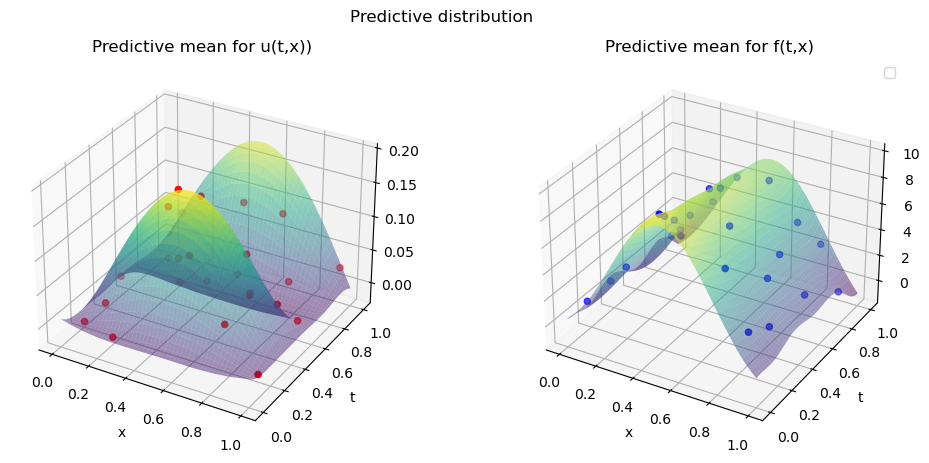

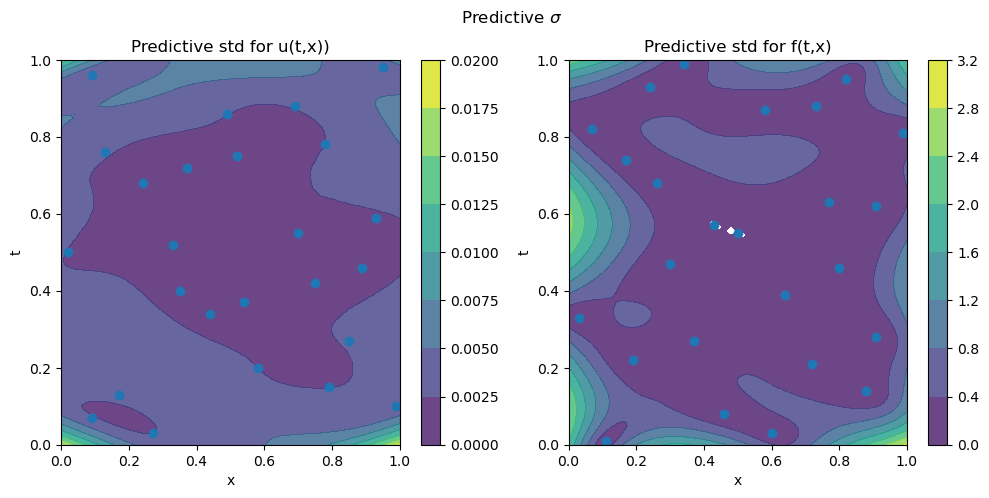

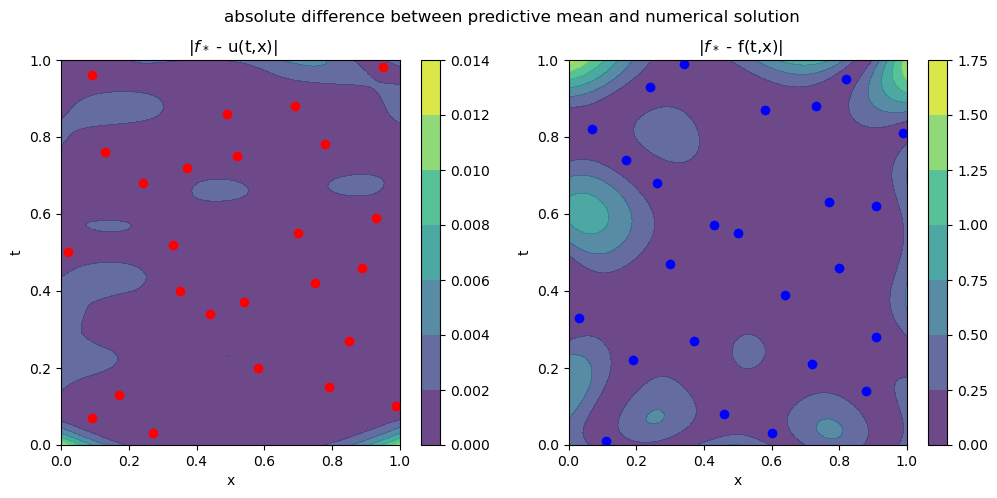

In [22]:
x_star, t_star = np.meshgrid(np.linspace(0,1,100), np.linspace(0,1,100))
X_star = np.hstack((x_star.reshape(-1,1),t_star.reshape(-1,1)))
model_2.predict_model(X_star)

model_2.var_u.shape
model_2.plot_prediction(X_star,"Predictive distribution","plots/wave_eq/prediction_2d.png")
model_2.error()
model_2.plot_variance(X_star,"Predictive $\\sigma$","plots/wave_eq/variance_2d.png")
model_2.plot_difference("absolute difference between predictive mean and numerical solution","plots/wave_eq/difference_2d.png")
print(model_2)


In [30]:
kernel1 = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
kernel2 = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
kernel = kernel1 + kernel2
m = GPy.models.GPRegression(model_2.X, model_2.Y, kernel)
m.optimize(messages=True)
x, t = np.linspace(0, 1, 100), np.linspace(0, 1, 100)
x, t = np.meshgrid(x, t)
x, t = x.reshape(-1,1), t.reshape(-1,1)
X = np.hstack((x, t))

mu, var = m.predict(X)
mu = mu.reshape((200, 200))
var = var.reshape((100, 100))
plt.contourf(x.reshape((100, 100)), t.reshape((100, 100)), mu, 100)


 c:\Users\Razer\anaconda3\lib\site-packages\GPy\core\gp.py:85: UserWarning:Your kernel has a different input dimension 1 then the given X dimension 2. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel


ValueError: cannot reshape array of size 20000 into shape (200,200)

 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\PI_GP_regressor\main_class.py:577: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\PI_GP_regressor\main_class.py:587: UserWarning:The balance properties of Sobol' points require n to be a power of 2.


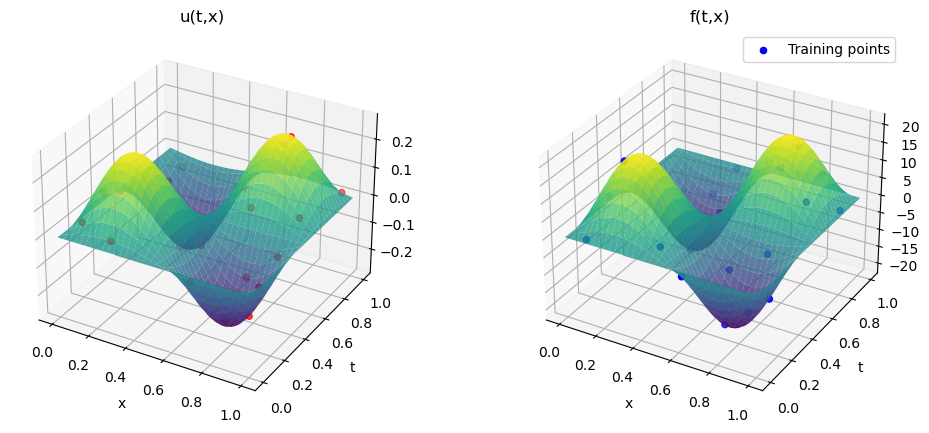

In [83]:
from main_class import PhysicsInformedGP_regressor
from kernels.kernel_heat_equation import k_ff_jax, k_uf_jax, k_fu_jax, k_uu_jax, gram_Matrix_jax
kernel = [gram_Matrix_jax,k_uu_jax, k_uf_jax, k_fu_jax, k_ff_jax]
params = ["l_x", "sigma_f_sq", "l_t", "alpha"]
model3 = PhysicsInformedGP_regressor(kernel=kernel,timedependence=True,params=params)
noise = [0.00001,0.00001]
model3.set_training_data("data_files/heat_data.csv",25,noise)
model3.plot_raw_data(Training_points=True)

In [84]:
import numpy as np
def get_initial_values():
    """returns the initial values for the hyperparameters
    for the length scales we initialize them randomly as log(l) ~ U(-2.5,1)
    """
    rng = np.random.default_rng()
    theta_initial = np.zeros((4))
    theta_initial[0] = np.exp(rng.uniform(-1.3, 0.3, 1))
    theta_initial[1] = rng.uniform(0, 2, 1)
    theta_initial[2] = np.exp(rng.uniform(-1.3, 0.3, 1))
    theta_initial[3] = rng.uniform(1, 4, 1)
    return theta_initial
n_iterations, n_threads = 100  0, -1
model3.train("TNC",n_iterations,n_threads,{'theta_initial': get_initial_values,   #needed for all optimization methods
                                            'bounds': ((1e-2, None), (1e-2, None), (1e-1, None),(1e-2, None)), #needed for TNC and L-BFGS-B
                                            'gtol': 1e-6})
 #needed for all optimization methods

 c:\Users\Razer\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning:A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
100%|██████████| 1000/1000 [05:31<00:00,  3.01it/s]


     fun: 10.74873161315918
     jac: array([-0.7841797 ,  0.07714844,  0.75878906, -0.97558594], dtype=float32)
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 99
     nit: 16
  status: 2
 success: True
       x: array([0.36350681, 0.23668739, 0.29185546, 2.01354229])


In [85]:
model3.log_marginal_likelohood([0.38629589, 0.45815171, 0.31977706, 2.01977359])

Array(11.05504, dtype=float32)